# Intro to Convolutional Neuron Network 

### Comp Club 4/17/19
Shih-Yi Tseng

<hr style="height:2pt">

##  Parts of Convolutional Neural Networks (Notes from Harvard 2019 CS109b)

There are common types of layers in a Convolutional Neural Network:

- Convolutional Layers
- Pooling Layers
- Dropout Layers
- Fully Connected Layers

### a. Convolutional Layers

Convolutional layers are comprised of **filters** and **feature maps**. The filters are essentially the **neurons** of the layer. They have the weights and produce the input for the next layer. The feature map is the output of one filter applied to the previous layer. 

The fundamental difference between a densely connected layer and a convolution layer is that dense layers learn global patterns in their input feature space (for example, for an image, patterns involving all pixels), whereas convolution layers learn local patterns: in the case of images, patterns found in small 2D windows of the inputs called *receptive fields*. 

This key characteristic gives convnets two interesting properties:

- The patterns they learn are **translation invariant**. After learning a certain pattern in the lower-right corner of a picture, a convnet can recognize it anywhere: for example, in the upper-left corner. A densely connected network would have to learn the pattern anew if it appeared at a new location. This makes convnets data efficient when processing images (because the visual world is fundamentally translation invariant): they need fewer training samples to learn representations that have generalization power.

- They can learn **spatial hierarchies of patterns**. A first convolution layer will learn small local patterns such as edges, a second convolution layer will learn larger patterns made of the features of the first layers, and so on. This allows convnets to efficiently learn increasingly complex and abstract visual concepts (because the visual world is fundamentally spatially hierarchical).

Convolutions operate over 3D tensors, called feature maps, with two spatial axes (height and width) as well as a depth axis (also called the channels axis). For an RGB image, the dimension of the depth axis is 3, because the image has three color channels: red, green, and blue. For a black-and-white picture, the depth is 1 (levels of gray). The convolution operation extracts patches from its input feature map and applies the same transformation to all of these patches, producing an output feature map. This output feature map is still a 3D tensor: it has a width and a height. Its depth can be arbitrary, because the output depth is a parameter of the layer, and the different channels in that depth axis no longer stand for specific colors as in RGB input; rather, they stand for filters. Filters encode specific aspects of the input data: at a high level, a single filter could encode the concept “presence of a face in the input,” for instance.

Convolutions are defined by two key parameters:
- Size of the patches extracted from the inputs. These are typically  3×3 or  5×5 
- The number of filters computed by the convolution. 

**Padding**: One of "valid", "causal" or "same" (case-insensitive).  "valid" means "no padding".  "same" results in padding the input such that the output has the same length as the original input.  "causal" results in causal (dilated) convolutions,

In `keras` see [convolutional layers](https://keras.io/layers/convolutional/)

**keras.layers.Conv2D**(filters, kernel_size, strides=(1, 1), padding='valid', activation=None, use_bias=True, 
                    kernel_initializer='glorot_uniform', data_format='channels_last', 
                    bias_initializer='zeros')

#### How are the values in feature maps calculated?

![title](convolution-many-filters.png)

### b. Pooling Layers

Pooling layers are also comprised of filters and feature maps. Let's say the pooling layer has a 2x2 receptive field and a stride of 2. This stride results in feature maps that are one half the size of the input feature maps. We can use a max() operation for each receptive field. 

In `keras` see [pooling layers](https://keras.io/layers/pooling/)

**keras.layers.MaxPooling2D**(pool_size=(2, 2), strides=None, padding='valid', data_format=None)

![Max Pool](MaxPool.png)

### c. Dropout Layers

Dropout consists in randomly setting a fraction rate of input units to 0 at each update during training time, which helps prevent overfitting.

In `keras` see [Dropout layers](https://keras.io/layers/core/)

keras.layers.Dropout(rate, seed=None)

rate: float between 0 and 1. Fraction of the input units to drop.<br>
seed: A Python integer to use as random seed.

References

[Dropout: A Simple Way to Prevent Neural Networks from Overfitting](http://www.jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf)

### d. Fully Connected Layers

A fully connected layer flattens the square feature map into a vector. Then we can use a sigmoid or softmax activation function to output probabilities of classes. 

In `keras` see [FC layers](https://keras.io/layers/core/)

**keras.layers.Dense**(units, activation=None, use_bias=True, 
                    kernel_initializer='glorot_uniform', bias_initializer='zeros')
                    
                    
                    

# Convolutional Neuron Network in Action: Source Classification


<hr style="height:2pt">

In this exercise, we will learn how to build a CNN to classify sources for 2-photon calcium imaging data. In 2-photon calcium imaging, we collect images of field of views through the microscope, and process those images (or movies) afterward to extract activity traces of ROIs, or what we call "sources", before doing further analysis. Open source softwares such as Suite2P (https://github.com/cortex-lab/Suite2P) or CNMF (https://github.com/flatironinstitute/CaImAn) are available for processing the images and extract sources, and at the end of this pipeline, we classify the sources into different categories and determine what we want to include in the downstream analysis.

Here is an example of the collection of all sources in one imaging plane of L2/3 cortex: 
![source](source_images.png)

Our task is to classify these sources into 4 categories using a CNN:

- **Class 0: Cell bodies**

- **Class 1: Small, vertical processes**

- **Class 2: Complex, horizontal processes or out-of-focus cells**

- **Class 3: Junk**

You'll see some examples in the following section.

<hr style="height:2pt">

## Importing libaries and functions

***

First we import some libraries and functions that we'll be using.

In [1]:
import numpy as np
np.random.seed(42)
import tensorflow as tf
tf.set_random_seed(11)
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.optimizers import SGD, Adam
import pickle
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline 

Using TensorFlow backend.


## Load data and visualize the sources
***

Run this cell to load data. 

In [2]:
with open('sources.pkl','rb') as file:
    sources = pickle.load(file)

This file contains 16000 images of different sources (height = 25, width = 25, number of channels = 1).

In [3]:
sources.shape

(16000, 25, 25, 1)

We have 4000 examples for each class (arranged in class order). So we can recreate the class labels (response variables) for each image. 

In [4]:
class_size = 4000
class_name = ['cell','vertical process','complex process', 'junk']
labels = [n * np.ones((class_size,1)) for n in range(len(class_name))]
labels = np.concatenate(labels, axis = 0).astype(int)

Let's also do some visualization and see how these images look like. Try to change the `n_source` and look at different sources.

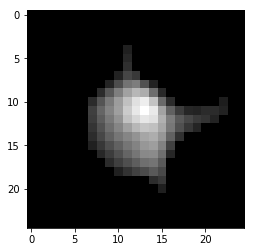

In [5]:
n_source = 0
plt.imshow(sources[n_source,:,:,0],cmap = 'gray')

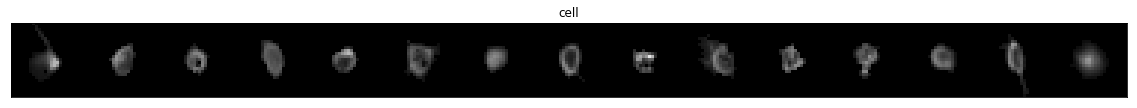

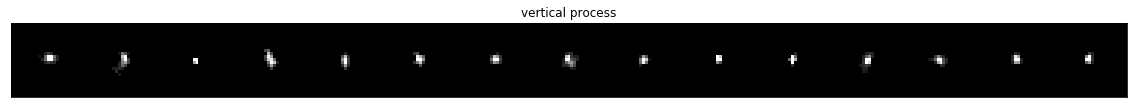

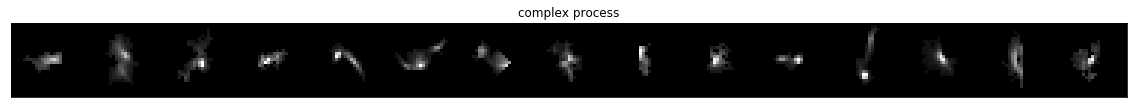

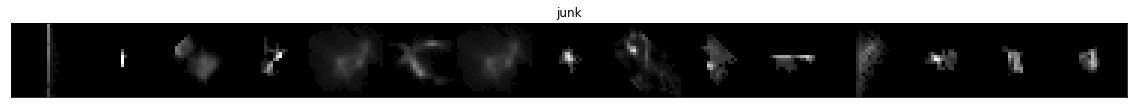

In [6]:
def plot_samples(class_id, n_samples = 16):
    sample_id = class_id * class_size + np.random.choice(class_size, size = (n_samples,))
    image_list = [sources[ii,:,:,0] for ii in sample_id]
    image_stack = np.hstack(image_list)
    plt.figure(figsize = (20,3))
    plt.imshow(image_stack, cmap = 'gray', vmin=None, vmax=0.4)
    plt.xticks([])
    plt.yticks([])
    plt.title(class_name[class_id])
    
for n_class in range(4):
    plot_samples(n_class, n_samples = 15)

## Prepare training/validation/test samples
***
As a standard practice for building machine learning models, we split our data into 3 portions: training, validation, and test sets using **train_test_split** funciton (https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) from sklearn. It also shuffle the data for you, conveniently.

Here we use 80% of samples for training, 10% for validation and 10% for testing.

In [7]:
# split 80-20 for train/test set
X_train, X_test, y_train, y_test = train_test_split(sources, labels, test_size = 0.2)

# further split the 20% in half for validation and true test set
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size = 0.5)

We also have to convert the labels into dummy variables (one column for each class) using keras utility function **to_categorical**.

In [8]:
# convert y to categorical
n_classes = 4
y_train = keras.utils.to_categorical(y_train, n_classes)
y_val = keras.utils.to_categorical(y_val, n_classes)
y_test = keras.utils.to_categorical(y_test, n_classes)

print(y_train.shape)

(12800, 4)


## Image augmentation using ImageDataGenerator
***

For training CNN on image classification, one commonly used method to prevent overfitting is to do image augmentation. We can manipulate the training images in several ways to create a larger training set, such as random rotations, shifts, zooms, etc. Here we are using the **ImageDataGenerator** from Keras for the augmentation.

You can find more options and description for the ImageDataGenerator from the documentation: https://keras.io/preprocessing/image/

In [9]:
train_datagen = ImageDataGenerator(
    rotation_range = 360,
    width_shift_range = 0.15,
    height_shift_range = 0.15,
    zoom_range = 0.15,
    horizontal_flip = True,
    vertical_flip = True)

# train_datagen.fit(X_train)

## Define the CNN model
***
We use Keras **Sequential** mode to build our model, in which we can stack layers on top of each other. And then we choose the **optimizer** we want to use, and **compile the model** with the optimizer, the loss function, and the metrics for evaluation. We can print out the summary of the model after compiling it.


Documentation for Sequential: https://keras.io/models/sequential/

In [10]:
# construct the model
model = Sequential()
model.add(Conv2D(32, (3, 3), padding = 'same', input_shape = X_train.shape[1:], activation = 'relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), padding = 'same', activation = 'relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), padding = 'same', activation = 'relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(256, activation = 'relu'))
model.add(Dense(4, activation = 'softmax'))

# set optimizer
opt = keras.optimizers.Adam(lr = 0.01)

# compile the model
model.compile(loss ='categorical_crossentropy', optimizer = opt, metrics = ['accuracy'])

# print out summary
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 25, 25, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 6, 6, 128)         73856     
_________________________________________________________________
max_pooling2d_3 (MaxP

## Train the model
***
Before training, we define the batch size and number of epochs. Since we are using the ImageDataGenerator to generate training data, we choose the **fit_generator** function to start fitting process. Other fitting methods are **fit** (feed in all training data at a time) and **train_on_batch** (perform single gradient descent on one batch). 

The information about the training process is returned as a **history** object. We can inspect the information in the history object and diagnose the training afterward.

In [11]:
# fit the model
batch_size = 1024
epochs = 30

history = model.fit_generator(train_datagen.flow(X_train, y_train, batch_size = batch_size),
                              steps_per_epoch = X_train.shape[0]/batch_size, 
                              epochs = epochs,
                              validation_data = (X_val, y_val), 
                              shuffle = True, 
                              workers = -1, 
                              verbose = 1)


Instructions for updating:
Use tf.cast instead.
Epoch 1/30
13/12 [===============================] - 12s 903ms/step - loss: 1.2628 - acc: 0.3801 - val_loss: 1.3395 - val_acc: 0.4594
Epoch 2/30
13/12 [===============================] - 11s 825ms/step - loss: 0.9718 - acc: 0.5617 - val_loss: 1.6885 - val_acc: 0.4094
Epoch 3/30
13/12 [===============================] - 11s 810ms/step - loss: 0.9265 - acc: 0.5781 - val_loss: 1.1040 - val_acc: 0.5269
Epoch 4/30
13/12 [===============================] - 11s 812ms/step - loss: 0.8710 - acc: 0.6045 - val_loss: 0.8764 - val_acc: 0.5956
Epoch 5/30
13/12 [===============================] - 11s 822ms/step - loss: 0.8466 - acc: 0.6156 - val_loss: 1.1433 - val_acc: 0.5294
Epoch 6/30
13/12 [===============================] - 11s 820ms/step - loss: 0.8247 - acc: 0.6491 - val_loss: 1.0923 - val_acc: 0.5944
Epoch 7/30
13/12 [===============================] - 11s 824ms/step - loss: 0.8893 - acc: 0.6263 - val_loss: 1.1390 - val_acc: 0.5656
Epoch 8/30
13/

## Visualize training process
***
In history.history, we can find the loss and accuracy on train/validation data for every epoch.

In [12]:
history.history.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

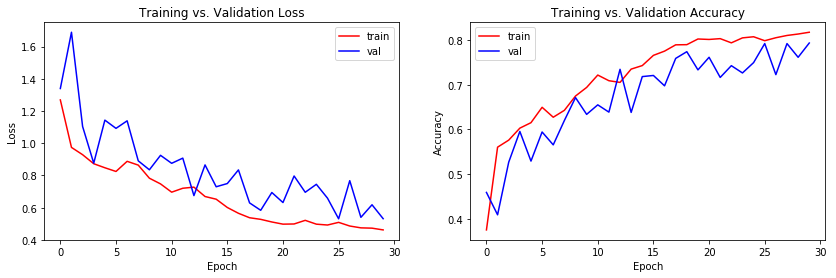

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(14,4))
ax[0].plot((history.history['loss']), 'r', label='train')
ax[0].plot((history.history['val_loss']), 'b' ,label='val')
ax[0].set(xlabel = 'Epoch', ylabel = 'Loss', title = 'Training vs. Validation Loss')
ax[0].legend()

ax[1].plot((history.history['acc']), 'r', label='train')
ax[1].plot((history.history['val_acc']), 'b' ,label='val')
ax[1].set(xlabel = 'Epoch', ylabel = 'Accuracy', title = 'Training vs. Validation Accuracy')
ax[1].legend();

## Evaluate the model
***
Now we use the **evaluate** function to see how our model performs on the test set.

In [14]:
result = model.evaluate(X_test, y_test)
print('loss = ', result[0], '\naccuracy =', result[1])

1600/1600 [==============================] - 0s 188us/step
loss =  0.4579680055379868 
accuracy = 0.8225


We can also use **predict** function to make prediction. It returns a vector of probability distribution over the 4 classes, so we use **np.argmax** to extract the predicted class labels.

In [15]:
y_pred = np.argmax(model.predict(X_test), axis = 1)
print('Average accuracy =', accuracy_score(np.argmax(y_test, axis = 1), y_pred))

Average accuracy = 0.8225


## Confusion matrix
***
For further inspect the model performance on each class, we typically plot the confusion matrix.

In [16]:
# use plotting function of confusion matrix from sklearn
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py

from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.figure(figsize=(8,8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Confusion matrix, without normalization
[[348   3  26  27]
 [  0 379   1  33]
 [  9  36 308  48]
 [  5  31  65 281]]

Sensitivity : [0.86138614 0.91767554 0.7680798  0.73560209]
Positive predictive value : [0.96132597 0.844098   0.77       0.72236504]


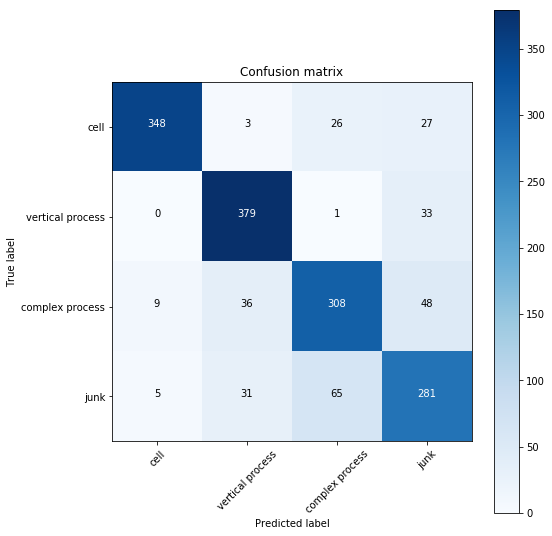

In [17]:
# plot the normalized confusion matrix
cm = confusion_matrix(np.argmax(y_test,axis = 1),y_pred)
plot_confusion_matrix(cm, class_name, normalize=False)

print('\nSensitivity :',np.diag(cm)/np.sum(cm,axis = 1))
print('Positive predictive value :',np.diag(cm)/np.sum(cm,axis = 0))

### How can we improve the performance?